# Create geological model and drillhole from sections

This is to extract points from geological model defined in sections (dxf files). We also generate drillhole data. The section must be defined as a dxf with layers properly defined:

<img src='figures/fig1.JPG' height = '50%' width = '50%'>
 


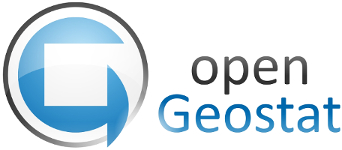

In [1]:
# import modules
import pygslib
import ezdxf
import pandas as pd
import numpy as np

Here we extract data from dxf sections. We extract points from lines and assign it to its corresponding object, defined by the dxf 'layer'. 

In [2]:
# get sections in dxf format, the suffix is the N coordinate (for now only for EW sections)
N = [-10, 0,50,100,150,200, 210]
s = {'x':[],  # North coordinates of the sections
     'y':[], 
     'z':[], 
     'layer':[],
     'id':[]}
pl_id = -1
for y in N:
    dwg = ezdxf.readfile('S_{}.dxf'.format(y))
    msp= dwg.modelspace()
    for e in msp.query('LWPOLYLINE'):
        p = e.get_rstrip_points()
        if e.dxfattribs()['layer']=='dhole':
            pl_id=pl_id+1
            aid = int(pl_id)
        else:
            aid = None        
        for j in p:
            s['x'].append(j[0])
            s['y'].append(y)
            s['z'].append(j[1])
            s['layer'].append(e.dxfattribs()['layer'])
            s['id'].append(aid)

S=pd.DataFrame(s)
S['id']=S['id'].values.astype(int)
print (S['layer'].unique())

['bbox' 'topo' 'fw' 'hw' 'dhole']


## Generate working region
For this to work we need to define a bounding box (working region) where the model and data will be will defined

In [3]:
# define working region 
xorg = -10.
yorg = -10.
zorg = -10.
dx = 5.
dy = 5.
dz = 5.
nx = 40
ny = 44
nz = 36

## Generate solids 
We are assuming we have stratigraphic units with contact surfaces that may be modeled individually, we defined surfaces interpolating in a 2D grid and optionally snapping points with known coordinates in 3D.
The surfaces are then used to obtain individual closed solids.


In [6]:
# get points defining each surface 
hw_p = S.loc[S['layer']=='hw',['x','y','z']]
fw_p = S.loc[S['layer']=='fw',['x','y','z']]
topo_p = S.loc[S['layer']=='topo',['x','y','z']]

In [7]:
# generate vtk open surfaces
topo,x_topo,y_topo,z_topo = pygslib.vtktools.rbfinterpolate(x=topo_p['x'].values.astype('float'),
                                       y=topo_p['y'].values.astype('float'),
                                       z=topo_p['z'].values.astype('float'),
                                       xorg=xorg, yorg=yorg,dx=dx,dy=dy,nx=nx,ny=ny,
                                       snap = False)

hw,x_hw,y_hw,z_hw  = pygslib.vtktools.rbfinterpolate(  x=hw_p['x'].values.astype('float'),
                                       y=hw_p['y'].values.astype('float'),
                                       z=hw_p['z'].values.astype('float'),
                                       xorg=xorg, yorg=yorg,dx=dx,dy=dy,nx=nx,ny=ny,
                                       snap = False)

fw,x_fw,y_fw,z_fw = pygslib.vtktools.rbfinterpolate(  x=fw_p['x'].values.astype('float'),
                                       y=fw_p['y'].values.astype('float'),
                                       z=fw_p['z'].values.astype('float'),
                                       xorg=xorg, yorg=yorg,dx=dx,dy=dy,nx=nx,ny=ny,
                                       snap = False)

# save the open surfaces
pygslib.vtktools.SavePolydata(topo, 'topo')
pygslib.vtktools.SavePolydata(hw, 'hw')
pygslib.vtktools.SavePolydata(fw, 'fw')

By now we have surfaces that can be used for modeling, but working with closed surfaces is easier in pygslib

<img src = 'figures/fig2.JPG' height="50%" width="50%">

Now you can use boolean operations on points evaluated with implicit functions to generate closed surfaces. The points, in this case, are defined in the region. Note that implicit surfaces could be used to select points (drillholes and block centroids) but will not allow you to easily calculate proportion of blocks inside a given domain.

Implicit surfaces require consistent normals to determine `inside` or `outside` and sign of  distances. The function `pygslib.vtktools.implicit_surface()` will update/calculate the normals. You can use the function `pygslib.vtktools.calculate_normals()` to invert the `inside` or `outside` direction of solids. 
  
The behaviour of implicit surfaces can be changed by manipulating the normals manually and setting update_normals==False in the function `pygslib.vtktools.implicit_surface()`
  
  


In [8]:
# create implicit surfaces
impl_topo = pygslib.vtktools.implicit_surface(topo)
impl_hw = pygslib.vtktools.implicit_surface(hw)
impl_fw = pygslib.vtktools.implicit_surface(fw)

In [9]:
# this is a grid (a box, we cut to generate geology). We can generate a grid ot tetras with surface point included to emulate snapping 
region = pygslib.vtktools.define_region_grid(xorg, yorg, zorg, dx/2, dy/2,  dz/4, nx*2, ny*2, nz*4) #, snapping_points = [topo,hw,fw])
pygslib.vtktools.SaveUnstructuredGrid(region, "region")

In [10]:
# evaluate surfaces
#below topo
region,topo_d = pygslib.vtktools.evaluate_region(region, implicit_func = impl_topo, func_name='topo_d', invert=False, capt = -10000)
#above hanging wall
region, hw_u = pygslib.vtktools.evaluate_region(region, implicit_func = impl_hw, func_name='hw_u', invert=True, capt = -10000)
#below hanging wall
region, hw_d = pygslib.vtktools.evaluate_region(region, implicit_func = impl_hw, func_name='hw_d', invert=False, capt = -10000)
#above footwall
region, fw_u = pygslib.vtktools.evaluate_region(region, implicit_func = impl_fw, func_name='fw_u', invert=True, capt = -10000)
#below footwall
region, fw_d = pygslib.vtktools.evaluate_region(region, implicit_func = impl_fw, func_name='fw_d', invert=False, capt = -10000)


# create intersection between hanging wall and foot wall
dom1= np.minimum(hw_d, fw_u)
region = pygslib.vtktools.set_region_field(region, dom1, 'dom1')
# extract surface
dom1_poly = pygslib.vtktools.extract_surface(region,'dom1')
# Save surface
pygslib.vtktools.SavePolydata(dom1_poly, 'dom1')

# create intersection between topo and hanging wall
dom_topo= np.minimum(topo_d, hw_u)
region = pygslib.vtktools.set_region_field(region, dom_topo, 'dom_topo')
# extract surface
dom_topo_poly = pygslib.vtktools.extract_surface(region,'dom_topo')
# Save surface
pygslib.vtktools.SavePolydata(dom_topo_poly, 'dom_topo')

# not boolean required below fw
# extract surface
dom_fw_poly = pygslib.vtktools.extract_surface(region,'fw_d')
# Save surface
pygslib.vtktools.SavePolydata(dom_fw_poly, 'dom_fw')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


by now we have a geological model defined with solids
<img src='figures/fig3.JPG' height="50%" width="50%" >

## Generate drillhole data
Now we extract drillhole traces from dxf files to:
- generate drillhole tables
- from tables generate drillhole object
- then we split drillhole data ('composite') and label drillhole intervals with Domain 1 (between hanging and footwall surfaces)



In [11]:
# generate table collar from dxf traces
tcollar = {}
tcollar['BHID'] = S.loc[S['layer']=='dhole','id'].unique()
tcollar['XCOLLAR'] = S.loc[S['layer']=='dhole',['x','id']].groupby('id').first().values.ravel().astype(float)
tcollar['YCOLLAR'] = S.loc[S['layer']=='dhole',['y','id']].groupby('id').first().values.ravel().astype(float)
tcollar['ZCOLLAR'] = S.loc[S['layer']=='dhole',['z','id']].groupby('id').first().values.ravel().astype(float)
collar = pd.DataFrame(tcollar)


In [12]:
# generate table survey from dxf traces
tsurvey = {'BHID':[], 'AT':[], 'DIP':[], 'AZ':[]}
for i in collar['BHID']:
    h = S.loc[(S['layer']=='dhole') & (S['id']==i),['x','y','z']].values
    x= h[1][0]-h[0][0]
    y= h[1][1]-h[0][1]
    z= h[1][2]-h[0][2]
    d0=np.sqrt(x**2+y**2+z**2)
    az,dip = pygslib.drillhole.cart2ang(x/d0,y/d0,z/d0)
    # add first interval
    tsurvey['BHID'].append(i)
    tsurvey['AT'].append(0)
    tsurvey['AZ'].append(az)
    tsurvey['DIP'].append(dip)
    for j in range(1,h.shape[0]):        
        x= h[j][0]-h[j-1][0]
        y= h[j][1]-h[j-1][1]
        z= h[j][2]-h[j-1][2]
        d=np.sqrt(x**2+y**2+z**2)
        az,dip = pygslib.drillhole.cart2ang(x/d,y/d,z/d)
        tsurvey['BHID'].append(i)
        tsurvey['AT'].append(d+d0)
        tsurvey['AZ'].append(az)
        tsurvey['DIP'].append(dip)
        d0 = d+d0
survey = pd.DataFrame(tsurvey)

In [13]:
# generate 'LENGTH' field of collar from table of surveys
collar['LENGTH'] = 0
for i in collar['BHID']:
    collar.loc[collar['BHID']==i, 'LENGTH'] = survey.groupby('BHID')['AT'].max()[i]
    

In [14]:
# generate a dummy assay table
assay = pd.DataFrame({'BHID':collar['BHID'],'TO':collar['LENGTH']})
assay['FROM'] = 0

In [15]:
# generate drillhole object
collar['BHID'] = collar['BHID'].values.astype('str')
survey['BHID'] = survey['BHID'].values.astype('str')
assay['BHID'] = assay['BHID'].values.astype('str')
assay['DUM'] = 0.

dhole = pygslib.drillhole.Drillhole(collar,survey)

In [16]:
# add assay table
dhole.addtable(assay, 'assay')

In [17]:
# validate results
dhole.validate()
dhole.validate_table('assay')

In [18]:
# composite. This is normally completed after tagging but we need small intervals here to emulate real assay table
dhole.downh_composite(table_name='assay',variable_name='DUM', new_table_name='cmp',cint = 1)

In [19]:
# desurvey and export
dhole.desurvey(table_name='cmp', endpoints=True, warns=True)
dhole.intervals2vtk('cmp','cmp')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


<img src='figures/fig4.JPG' height="50%" width="50%" >

# Tag drillholes with domain code

There are two main ways here: 
- tagging samples using implicit functions with surfaces 
- tagging samples using implicit functions with solids

The easiest is using solids. 

In the first case we evaluate the distance between a point and a surface using the function `pygslib.vtktools.evaluate_implicit_points()`. The output of this function is a signed distance, where sign indicates:
- negative: the point is inside or above
- positive: the point is outside or below
- zero: the point is in the surface

The samples between two surfaces can be selected by evaluating the points with the two implicit surfaces and doing boolean operation with signed values

In [20]:
# tag using surfaces 
dhole.table['cmp']['dist_hw'] = pygslib.vtktools.evaluate_implicit_points(implicit_mesh=impl_hw, 
                                              x=dhole.table['cmp']['xm'].values, 
                                              y=dhole.table['cmp']['ym'].values, 
                                              z=dhole.table['cmp']['zm'].values, 
                                              cap_dist=1, 
                                              normalize=False)


dhole.table['cmp']['dist_fw'] = pygslib.vtktools.evaluate_implicit_points(implicit_mesh=impl_fw, 
                                              x=dhole.table['cmp']['xm'].values, 
                                              y=dhole.table['cmp']['ym'].values, 
                                              z=dhole.table['cmp']['zm'].values, 
                                              cap_dist=1, 
                                              normalize=False)
dhole.table['cmp']['D1_surf'] = np.round((dhole.table['cmp']['dist_fw']+dhole.table['cmp']['dist_hw'])/2) 
dhole.intervals2vtk('cmp','cmp')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [21]:
# tag using solid dom1
inside1 = pygslib.vtktools.pointinsolid(dom1_poly, 
                       x=dhole.table['cmp']['xm'].values, 
                       y=dhole.table['cmp']['ym'].values, 
                       z=dhole.table['cmp']['zm'].values)

dhole.table['cmp']['D1_solid'] = inside1.astype(int)
dhole.intervals2vtk('cmp','cmp')


C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


# Modeling block model


In [22]:
mod = pygslib.blockmodel.Blockmodel(xorg=xorg, yorg=yorg, zorg=zorg, dx=dx*2,dy=dy*2,  dz=dz*2, nx=nx/2, ny=ny/2, nz=nz/2)
mod.fillwireframe(surface=dom1_poly)
mod.blocks2vtkImageData(path='d1_mod')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


(vtkCommonDataModelPython.vtkImageData)000001FFA75A9B28

when blocks are too large compared to solid resolution this algorithm fails, and require refinement

<img src='figures/fig6.JPG' height="50%" width="50%">

In [23]:
mod = pygslib.blockmodel.Blockmodel(xorg=xorg, yorg=yorg, zorg=zorg, dx=dx,dy=dy,  dz=dz/2, nx=nx, ny=ny, nz=nz*2)
mod.fillwireframe(surface=dom1_poly)
mod.blocks2vtkImageData(path='d1_mod')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


(vtkCommonDataModelPython.vtkImageData)000001FFA75A9C48

working with smaller blocks fix this problem

<img src='figures/fig7.JPG' height="50%" width="50%">


## Simulated Au grades in fine grid

In [24]:
# block model definition of xorg is for the corner of the block. To align this with GSLIB grids use xorg-dx/2
sim_grid = pygslib.blockmodel.Blockmodel(xorg=xorg, yorg=yorg, zorg=zorg, 
                                         dx=dx/5,dy=dy/5,  dz=dz/5, nx=nx*5, ny=ny*5, nz=nz*5)
sim_grid.fillwireframe(surface=dom1_poly)

(vtkCommonDataModelPython.vtkImageData)000001FFA75A9CA8

In [25]:
print (sim_grid.xorg, sim_grid.yorg, sim_grid.zorg)
print (sim_grid.nx, sim_grid.ny, sim_grid.nz)
print (sim_grid.dx, sim_grid.dy, sim_grid.dz)

-10.0 -10.0 -10.0
200 220 180
1.0 1.0 1.0


In [26]:
import subprocess
subprocess.call('echo sgsim.par | c:\gslib\sgsim.exe',shell=True)


0

In [27]:
sim1=pygslib.gslib.read_gslib_file('sgsim.out')
sim_grid.bmtable['sim1'] = np.exp(sim1['value'].values)*sim_grid.bmtable['__in'].values # to emulate Au grade with lognormal distribution
sim_grid.blocks2vtkImageData(path='sim1')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


(vtkCommonDataModelPython.vtkImageData)000001FFA75A9AC8

## Assigning grade to drillholes

In [28]:
# we migrate block data to points within blocks
dhole.table['cmp']['Au']=sim_grid.block2point(dhole.table['cmp']['xm'].values, 
                                            dhole.table['cmp']['ym'].values, 
                                            dhole.table['cmp']['zm'].values, 
                                            'sim1')

In [29]:
dhole.intervals2vtk('cmp','cmp')

C:\Users\AMartinez\AppData\Local\Continuum\miniconda3\lib\site-packages\vtk\util\numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


<img src = 'figures/fig8.JPG'>

In [30]:
dhole.collar.to_csv('collar.csv', index = False)
dhole.survey.to_csv('survey.csv', index = False)
dhole.table['cmp'].to_csv('assay.csv', index = False)